## Kaggle ML & DS Survey

## We always need to compute the similarity in meaning between texts.

Search engines need to model the relevance of a document to a query, beyond the overlap in words between the two. For instance, question-and-answer sites such as Quora or Stackoverflow need to determine whether a question has already been asked before.

In legal matters, text similarity task allow to mitigate risks on a new contract, based on the assumption that if a new contract is similar to a existent one that has been proved to be resilient, the risk of this new contract being the cause of financial loss is minimised. Here is the principle of Case Law principle. Automatic linking of related documents ensures that identical situations are treated similarly in every case. Text similarity foster fairness and equality. Precedence retrieval of legal documents is an information retrieval task to retrieve prior case documents that are related to a given case document.

In customer services, AI system should be able to understand semantically similar queries from users and provide a uniform response. The emphasis on semantic similarity aims to create a system that recognizes language and word patterns to craft responses that are similar to how a human conversation works. For example, if the user asks “What has happened to my delivery?” or “What is wrong with my shipping?”, the user will expect the same response.

![](https://websitedesign9100.blogspot.com/2019/11/blog-post.html)

In [ ]:
!pip install pyLDAvis==3.4.0
# !pip install --upgrade scikit-bio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.3 MB/s eta 0:00:00


Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

Read data from csv file

In [ ]:
questions = pd.read_csv('questions.csv', low_memory=False)

Print the first 5 rows of data

In [ ]:
questions.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...


This code block prepares a text corpus for analysis by extracting all entries from a column in a dataframe ('questions' in this case) and storing them in a list ('corpus'). The resulting corpus can then be processed and analyzed using natural language processing techniques.






In [ ]:
# Preparing a corpus for analysis and checking all entries
col = questions.columns[1:]
corpus=[]
a=[]
for q in col:
        a=questions[q][0]
        corpus.append(a)
        
corpus

['What is your age (# years)?',
 'What is your gender? - Selected Choice',
 'In which country do you currently reside?',
 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 'What is the size of the company where you are employed?',
 'Approximately how many individuals are responsible for data science workloads at your place of business?',
 'Does your current employer incorporate machine learning methods into their business?',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice',
 'What is your current yearly compensation (approximate $USD)?',
 'Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?',
 'Who/what are your favorite media sources that report on data science topics

This code block sets up the temporary folder location for storing a dictionary and corpus files during natural language processing. It also sets up the logging format and level for the process.






In [ ]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

This code block removes common words and punctuation marks from a corpus and tokenizes it. Then, it creates a dictionary of the tokens and saves it in the temporary folder.






In [ ]:
# removing common words and tokenizing
from gensim import corpora
stoplist = stopwords.words('english') + list(punctuation) + list("([)]?") + [")?"]

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'kaggle_survey.dict'))  # store the dictionary, for future reference

This code block generates a bag-of-words representation of the pre-processed text data and saves it as a Matrix Market format file for later use. It first uses a previously generated dictionary to convert each document (text) to a sparse vector, which is then stored in the corpus object. The corpus object is then serialized and stored to disk.






In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'kaggle_survey.mm'), corpus)  # store to disk, for later use

In the previous cells, I created a corpus of documents represented as a stream of vectors. To continue, lets use that corpus, with the help of Gensim.

# Creating a transformation

The transformations are standard Python objects, typically initialized by means of a training corpus:

Different transformations may require different initialization parameters; in case of TfIdf, the “training” consists simply of going through the supplied corpus once and computing document frequencies of all its features.
Training other models, such as Latent Semantic Analysis or Latent Dirichlet Allocation, is much more involved and,
consequently, takes much more time.

This code block initializes a TF-IDF (Term Frequency-Inverse Document Frequency) model using the models.TfidfModel() function on the corpus.






In [ ]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

## Note
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where TfIdf vectors are expected, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

**From now on, tfidf is treated as a read-only object that can be used to apply a transformation to a whole corpus:**

This code block creates a new corpus where the term frequency is adjusted by the inverse document frequency (TF-IDF) for each document in the original corpus. This is done using the pre-trained tfidf model and the corpus generated earlier. The resulting corpus_tfidf is a transformed version of the original corpus.






In [ ]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

# LDA:

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

In [ ]:
total_topics = 5

This code block initializes an LDA model with a given number of topics using the Gensim library. It then applies the LDA model to the corpus previously transformed by the TF-IDF model, resulting in a new corpus represented by the LDA model.






In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [ ]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.048*"machine" + 0.048*"learning" + 0.033*"approximately" + 0.033*"business?" + 0.033*"many"'),
 (1,
  '0.081*"selected" + 0.080*"choice" + 0.071*"(select" + 0.068*"apply)" + 0.065*"regular"'),
 (2,
  '0.026*"within" + 0.026*"level" + 0.026*"highest" + 0.026*"plan" + 0.026*"attained"'),
 (3,
  '0.038*"country" + 0.038*"currently" + 0.038*"reside?" + 0.007*"(select" + 0.007*"choice"'),
 (4,
  '0.048*"choice" + 0.048*"selected" + 0.025*"use" + 0.025*"(select" + 0.025*"apply)"')]

This code block creates a dictionary containing the top 25 words for each of the topics generated by LDA model.






In [ ]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

This code block creates a Pandas dataframe from the LDA topic models and fills any missing values with 0, then prints the shape of the resulting dataframe.






In [ ]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

In [ ]:
df_lda

,machine,learning,years?,methods,tpu,business?,incorporate,employer,ever,(tensor,...,many,automl,automated,tools),media,partial,sources,who/what,topics?,courses?
0,0.034436,0.034269,0.030107,0.019119,0.019109,0.019108,0.019102,0.019102,0.019095,0.019094,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
1,0.000000,0.000000,0.000000,0.011695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
3,0.012385,0.011846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,0.026125,0.026253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015524,0.014009,0.014008,0.014007,0.014005,0.014004,0.014003,0.014002,0.014001,0.014


This code block generates a cluster map using seaborn library, which visualizes the correlation between the topics obtained from LDA topic modeling. The colormap represents the correlation coefficients and the x/y axes represent the topics.






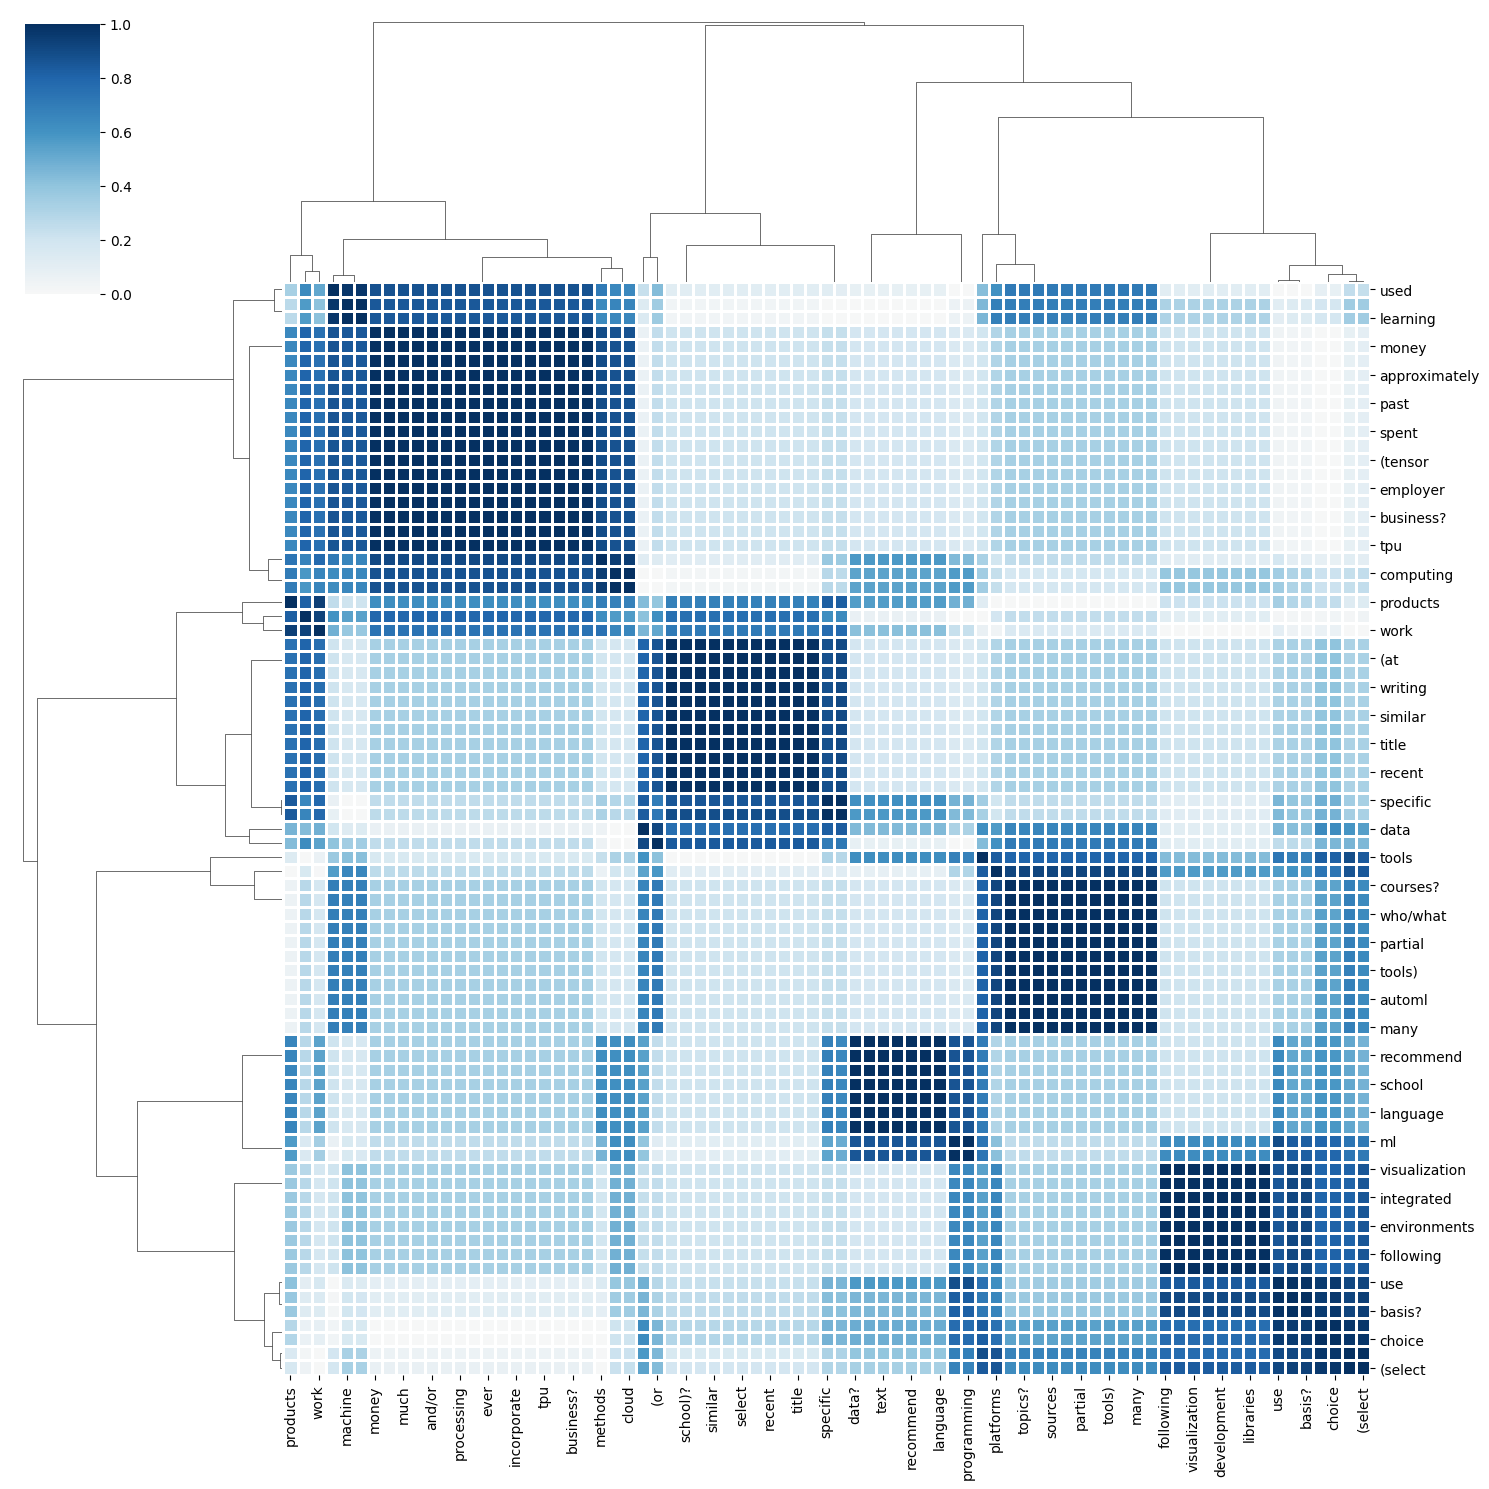

In [ ]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [ ]:
import pyLDAvis.gensim

This code block creates an interactive visualization of the LDA topic model using the pyLDAvis library, which allows for exploration of the relationships between topics and their associated keywords.






In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      -6.925752 -11.391700       1        1  40.547445
3     -23.233652  -7.774967       2        1  29.245789
4     -33.463959 -21.727722       3        1  10.114059
2      -2.577613 -28.121853       4        1  10.080640
0     -19.207998 -30.569118       5        1  10.012066, topic_info=         Term      Freq     Total Category  logprob  loglift
45    (select  1.000000  1.000000  Default  30.0000  30.0000
47     apply)  1.000000  1.000000  Default  29.0000  29.0000
3      choice  1.000000  1.000000  Default  28.0000  28.0000
5    selected  1.000000  1.000000  Default  27.0000  27.0000
43    machine  0.000000  0.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
44    methods  0.065083  0.324885   Topic5  -3.9571   0.6936
65       work  0.062745  0.311680   Topic5  -3.9937   0.6985
59  computing  0.062822  0.324087   Topic5  -3.9924   0.6607
58      cloud  0.062733  0.323991   Topic5  -3.9938   0.6596
63   products  0.062889  0.539451   Topic5  -3.9914   0.1522

[231 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
45        2  0.695315   (select
47        1  0.719735    apply)
47        2  0.719735    apply)
91        2  0.762764    basis?
3         1  0.546127    choice
3         2  0.546127    choice
96        1  0.760030   regular
96        2  0.760030   regular
5         1  0.544862  selected
5         2  0.544862  selected
84        1  0.687794       use
84        2  0.687794       use, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1])